# Modelling of k-growing graphs and privacy for eta-AD

This notebook is for interactive review and reproduction of the results of the associated paper.

## Preamble

### Packages

We will need some packages, if you run this on binder, the packages will be available through the requirements.txt

Within the notebook you could install them using the commands in the following cell.

In [12]:
# import sys
# !{sys.executable} -m pip install numpy python-igraph matplotlib scipy

### Autoreload

If you require autoreload features (e.g, because you change associated scripts), you use the magic commands in the following cell.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preamble

The following cell imports every aspect we use in this notebook.

In [16]:
from plotting import *
from helpers import *
from data import base, val1, val2
from models import Ms, Ss, prediction
from scipy.optimize import curve_fit
from scipy.stats import poisson, planck, geom, norm, lognorm, binom, truncnorm, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import math
import random

## Results

### Testcase

We generate a testcase with a certain number of nodes and edges. You can modify the number and all cells based on the testcase will compute new results.

In [17]:
nodes = 2000
edges = 6
testcase = gen_testcase(nodes, edges)

The testcase result has the following format:

 * 'freq': The frequencies of the distances 0-n
 * 'x': The range of the distances (i.e., 0-n)
 * 'x2': The range extended by f (i.e., 0-n+5) for displaying purposes
 * 'x3': The range of the distances as numpy linear space (0-n)
 * 'x4': The extended range as linear space (0-n+5)
 * 'expandeddata': A set of numbers corresponding to the frequencies, i.e., a list of distances of fixed length.

## Discrete Distributions

First we take a look at discrete distributions.

We investigated the following distributions based on manually implemented maximum likelihood estimators (MLE) (as they are not provided by scipy):
    
    * Poisson distribution (poifit)
    * Planck distribution (plafit)
    * Geometric distribution (geofit)
    * Binomial distribution

As the binomial distribution MLE uses the mean and variance, which are potentially non-integers, we computed these as either the ceiling of floor version of the values.

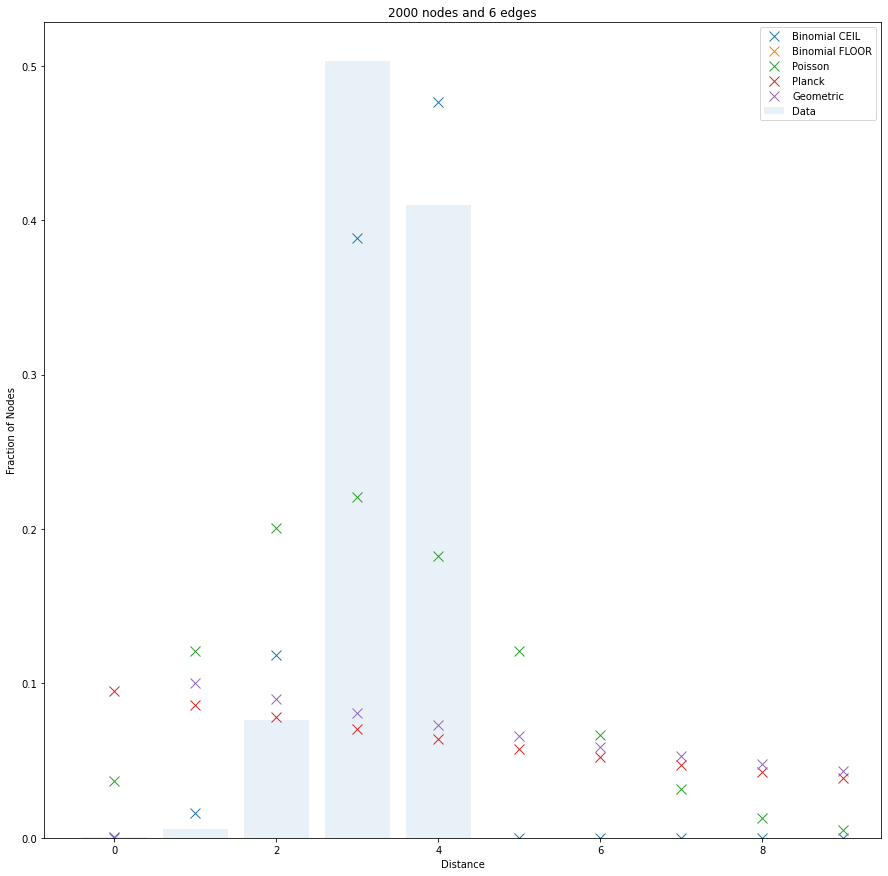

In [18]:
plt.figure(figsize=(15,15))

# baseic range
x = testcase["x"]
# extended range
x2 = testcase["x2"]

marksize = 10

# manual maximum likelihood fitting
# as those are not supported directly by scipy
poifit = poisson(sum([a*b for a, b in zip(testcase["freq"], x)]))
plafit = planck(1/sum(x))
geofit = geom(1/sum(x))
# binomial fit
var = np.var(testcase["expandeddata"])
m = np.mean(testcase["expandeddata"])
p = 1 - var/m
n = m/p
binfit = binom(math.ceil(n), m/math.ceil(n))
binfit2 = binom(math.floor(n), m/math.floor(n))

plt.plot(x2, binfit.pmf(x2), 'x', markersize=marksize, label="Binomial CEIL")
plt.plot(x2, binfit2.pmf(x2), 'x', markersize=marksize, label="Binomial FLOOR")

plt.bar(x, testcase["freq"], label="Data", alpha=0.1)

fits = [poifit, plafit, geofit]
names = ["Poisson", "Planck", "Geometric"]

for fit, name in zip(fits, names):
    plt.plot(x2, fit.pmf(x2), 'x', markersize=marksize, label=name)
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.xlabel("Distance")
plt.ylabel("Fraction of Nodes")
plt.show()

## Continuous Distributions

We investigated the following continuous distributions:

 * Normal distribution (due to the central limit theorem)
 * Truncated Normal distribution (due to it's limited support, a more realistic representation of our case)
 * Weibull distribution (as an extreme value distribution)

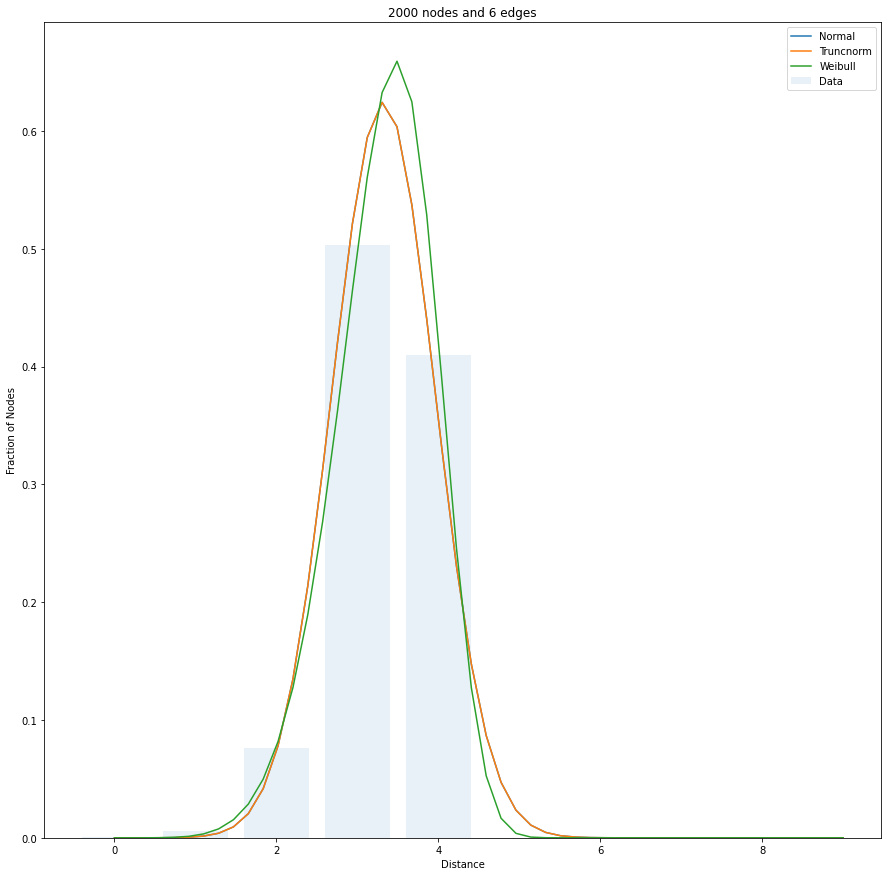

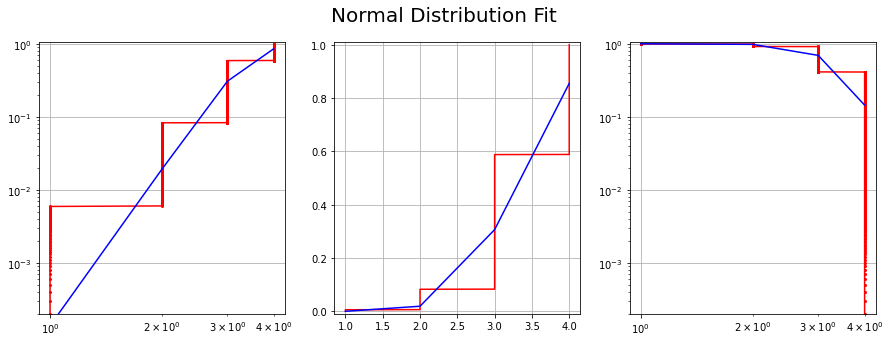

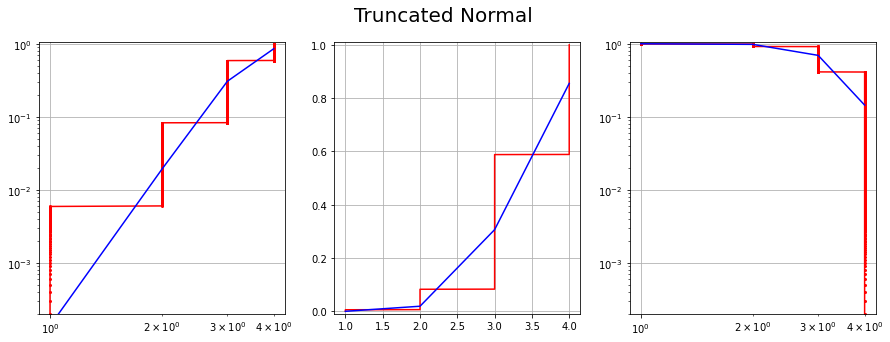

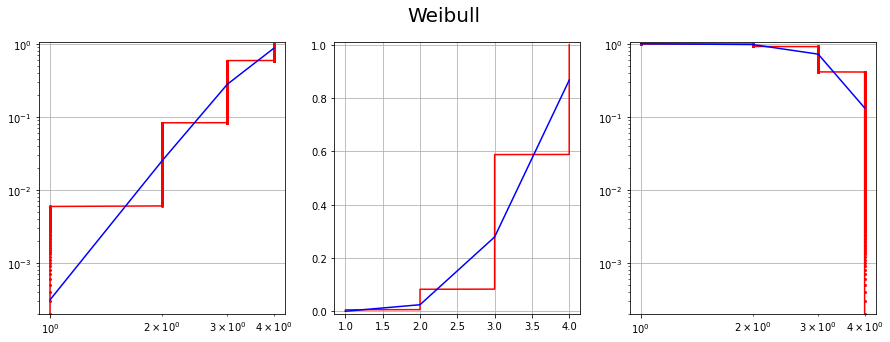

In [19]:
# continuous distributions
plt.figure(figsize=(15,15))
plt.bar(testcase["x"], testcase["freq"], label="Data", alpha=0.1)
x = testcase["x3"]

# fit normal distribution
m, s = norm.fit(testcase["expandeddata"])

# Note that the normal distributino is likely overlapped by the truncated normal distribution
plt.plot(x, norm.pdf(x, m, s), label="Normal")
plt.xlabel("Distance")
plt.ylabel("Fraction of Nodes")

# fit truncated nromal
i1, i2, i3, i4 = truncnorm.fit(testcase["expandeddata"])
plt.plot(x, truncnorm.pdf(x, (-m)/s, (1000-m)/s, loc=m, scale=s), label="Truncnorm")

# fit weibull
d, e, f = weibull_min.fit(testcase["expandeddata"], floc=0)
plt.plot(x, weibull_min.pdf(x, d, e, f), label="Weibull")

# plot everything together
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.show()

# Detailed comparissons for Normal, Truncated normal and Weibull distribution
plot_and_compare_cdf(testcase["expandeddata"], norm(m, s), "Normal Distribution Fit")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], truncnorm((-m)/s, (1000-m)/s, loc=m, scale=s), "Truncated Normal")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], weibull_min(d, e, f), "Weibull")
plt.show()

## Parameter Estimation

After selecting the normal distribution as least complex of the best fitting models, we are interested in parameters mu/sigma for such a distribution. Those should be based on nodes/edges.

In [20]:
# ranges for data
ks = range(min(base["edges"]),max(base["edges"])+2,2)
ns = base["unique_nodes"]

# numpy space for functions
Ks = np.linspace(min(base["edges"]),max(base["edges"]))
Ns = np.linspace(min(ns),max(ns))

# grid for 3D presentation
NsMG, KsMG = np.meshgrid(Ns, Ks)

### Prepared Datasets

We have multiple prepared datasets. We used the base set to analyse and fit our models. The dataset consists of mu/sigma values for a wide range of randomly generated graphs.

First, we investigate the landscape of the means of those values for every parameter combination.

Text(0.5, 0, 'Sigma')

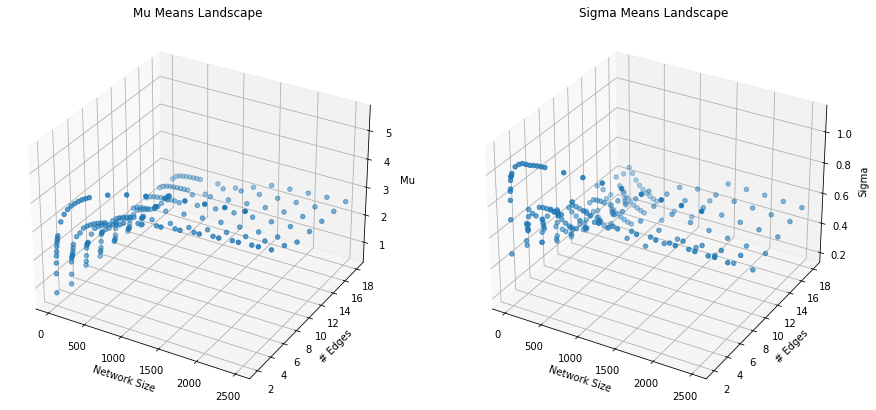

In [21]:
dataset = base
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Mu Means Landscape")
ax.scatter(dataset["nodes"],dataset["edges"], dataset["mu_means"])
ax.set_xlabel("Network Size")
ax.set_ylabel("# Edges")
ax.set_zlabel("Mu")
ax = fig.add_subplot(122, projection='3d')
ax.set_title("Sigma Means Landscape")
ax.scatter(dataset["nodes"],dataset["edges"], dataset["si_means"])
ax.set_xlabel("Network Size")
ax.set_ylabel("# Edges")
ax.set_zlabel("Sigma")

We split the 2 dimensional data by dimension for a first analysis.

### Edge Dimension

The edge dimension behaves approximately in a logarithmic fashion for mu. Sigma is less pronounced (i.e., the residus are much more extreme) but show the same behaviour as the residues of the mu analysis (a sawtooth or sharp periodic function with logarithmically increasing period).

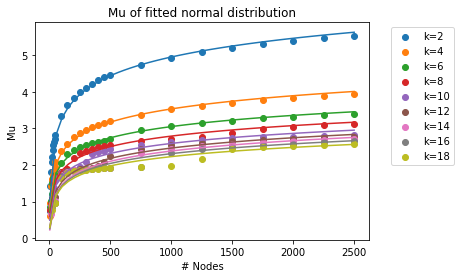

In [22]:
# Behaviour of Mu based on variable edge count
# Estimated behaviour is proportional to log(n)

def logx(x, a, b, c):
    return a*np.log(x*b)+c
Ns = np.linspace(min(base["unique_nodes"]),max(base["unique_nodes"]))

for k in range(min(base["edges"]),max(base["edges"])+2,2): # Plotting all: base["unique_nodes"]
    # Data
    ks = [i for i,x in enumerate(base["edges"]) if x == k]
    ns = [base["nodes"][i] for i in ks]
    mus = [base["mu_means"][i] for i in ks]
    plt.scatter(ns, mus, label=f"k={k}")
    # Fit
    for i in range(20):
        try:
            # for some parameters there are convergence problems
            # but some additoinal attemps finds a solution usually
            fit = curve_fit(logx, ns, mus, bounds=([np.NINF, 0, np.NINF], [np.Inf,np.Inf, np.Inf]))[0]
            break
        except (RuntimeError,np.linalg.LinAlgError):
            continue
    curve = lambda x: logx(x, fit[0], fit[1], fit[2])
    plt.plot(Ns, curve(Ns))
plt.xlabel("# Nodes")
plt.ylabel("Mu")
plt.title("Mu of fitted normal distribution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Nodes Dimension

The nodes dimension seems to behave proportional to $\frac{1}{e^k}$ based on the edge count k.

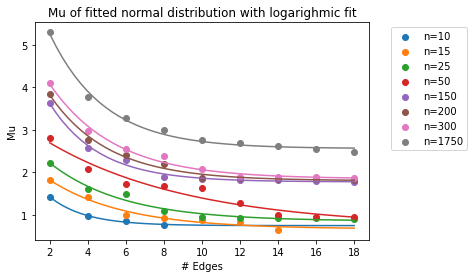

In [23]:
# Behaviour of Mu based on variable edge count
# Estimated behaviour is proportional to 1/exp(k)

def expx(x, a, b, c):
    return c+(a/np.exp(b*x))
Ks = np.linspace(min(base["edges"]),max(base["edges"]))

for n in sorted(random.sample(base["unique_nodes"], 8)): # Plotting all: base["unique_nodes"]
    # Data
    ns = [i for i,x in enumerate(base["nodes"]) if x == n]
    ks = [base["edges"][i] for i in ns]
    mus = [base["mu_means"][i] for i in ns]
    plt.scatter(ks, mus, label=f"n={n}")
    # Fit
    if len(mus) < 4:
        # not enough data
        continue
    fit = curve_fit(expx, ks, mus)[0]
    curve = lambda x: expx(x, fit[0], fit[1], fit[2])
    plt.plot(Ks, curve(Ks))
plt.xlabel("# Edges")
plt.ylabel("Mu")
plt.title("Mu of fitted normal distribution with logarighmic fit")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Fit evaluation

To evalute the fits, we first show the 4 models for mu overlaying the data.

As a reminder, the models are:
    
$$M_1(n,k) = \alpha \ln(\beta n) + \frac{\gamma}{e^{\delta k}} + \epsilon,$$

$$ M_2(n,k) = \frac{\alpha \ln(\beta n)}{e^{\gamma k}} + \delta \ln(\eta n) + \frac{\zeta}{e^{\gamma k}} + \epsilon, $$

$$ M_3(n,k) = \frac{\alpha \ln(\beta n)}{e^{\gamma k}} + \epsilon, $$

$$ M_4(n,k) = \frac{\alpha \ln(\beta n)}{e^{\gamma k}} - \frac{\alpha \delta k}{e^{\gamma k}} + \frac{\zeta}{e^{\eta k}} + \frac{\theta \ln(\iota n)}{(\kappa n)^{\lambda n}} +\nu \ln(\xi n). $$

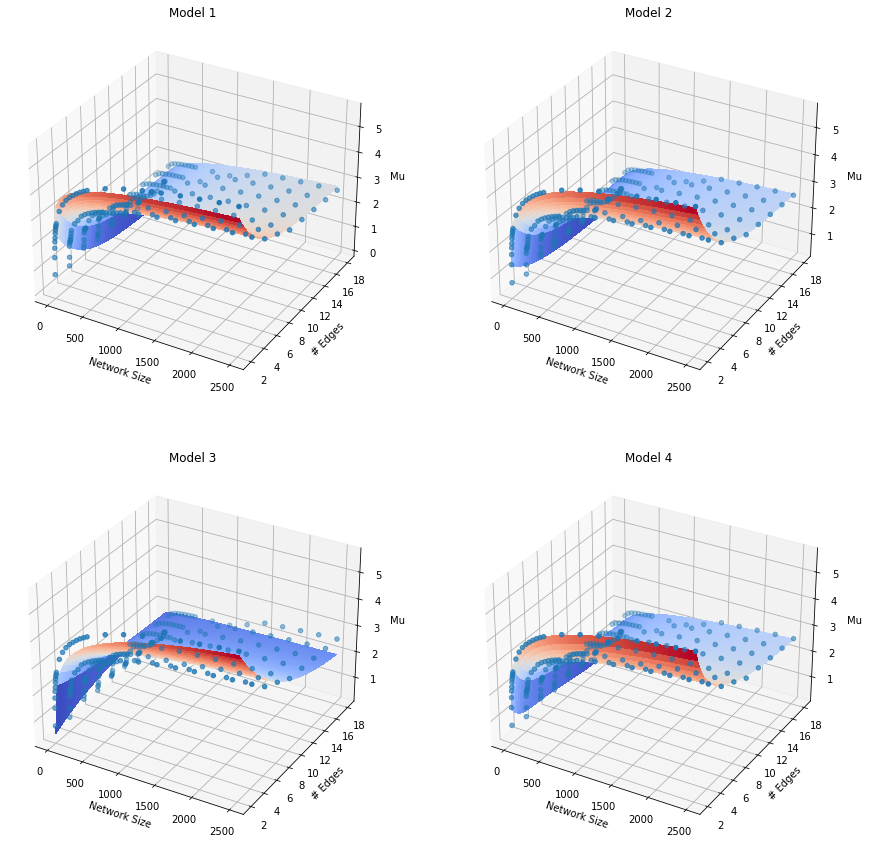

In [24]:
# Visual Model fits?
titles = ["Model 1", "Model 2", "Model 3", "Model 4"]
plot_3d_fit(base, Ms, titles)

### Using Validation Datasets

We also prepared 2 validation datasets.

The error represents the square deviation from the measured and fitted results compared to the calculated results. The model index is the same as previous.

The first graph is in logscale to emphasise the lower end of the boxplots.

The second graph is in linear scale, emphasasing the upper end of the boxplots.

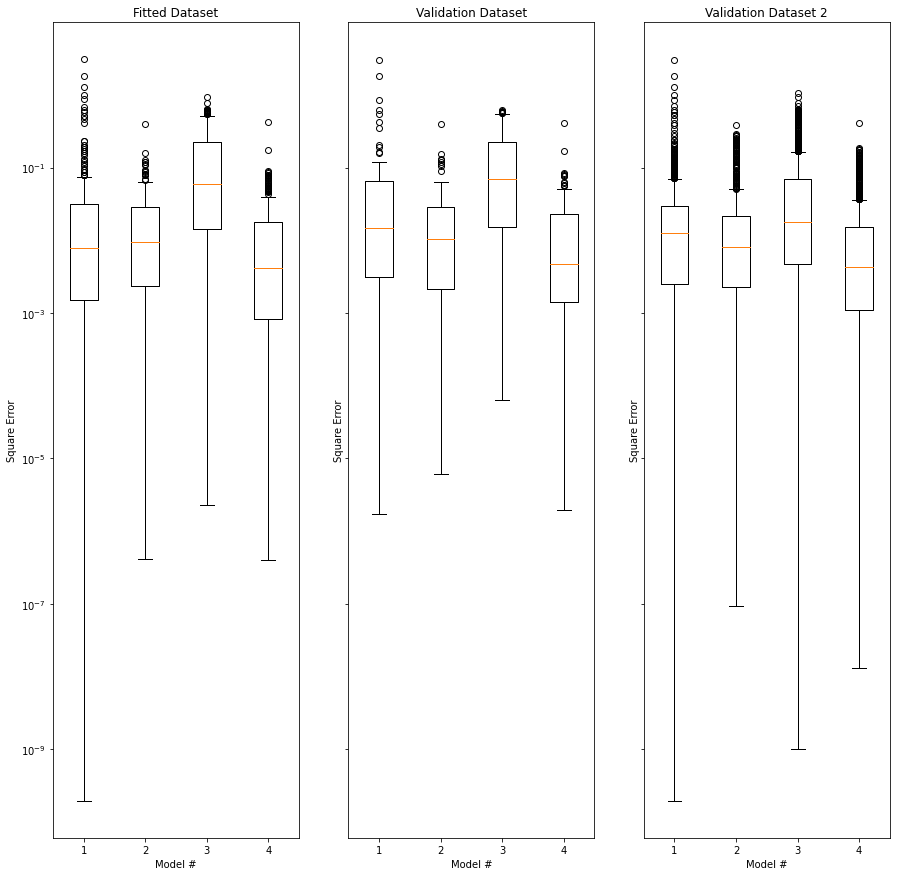

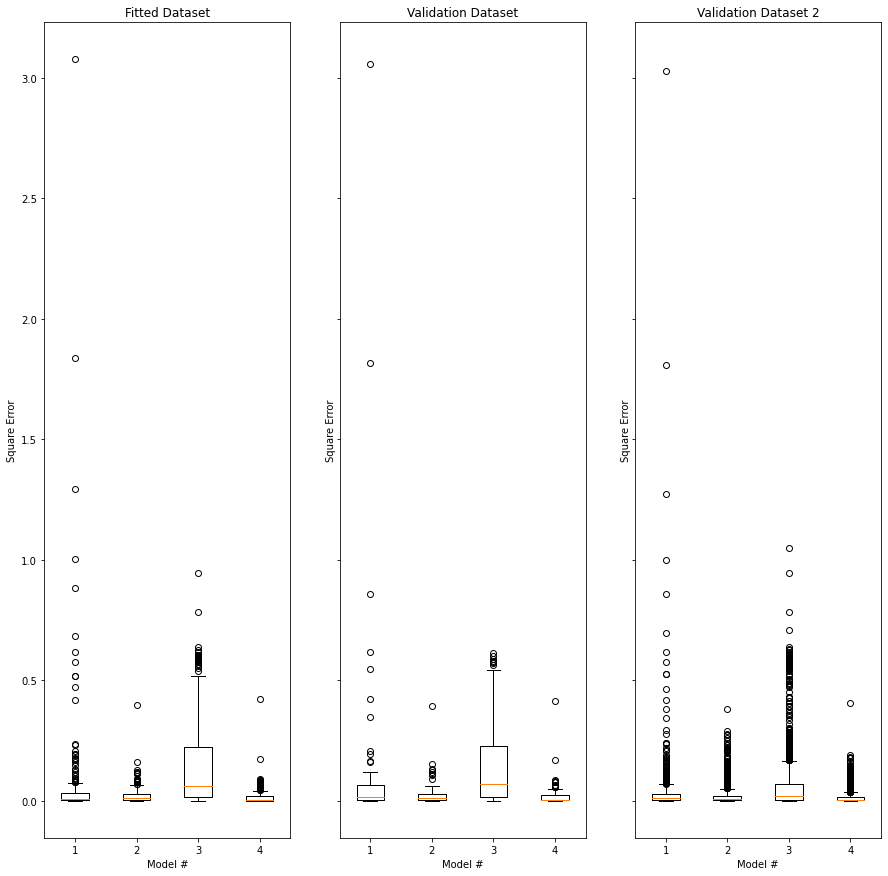

In [25]:
# Logscale version to emphasis lower end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error")
# Linear version to emphasis upper end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error", False)

## Reconstruction and Discretization

This repesents the discretized results for our previous example. The data from the graph is shown with the calculated normal distribution and two example discretizations.

The prediction is based on model 2 for µ and model 1 for sigmam.

The discretizations used are:

 * Pointwise: evaluate points of the normal distribution PDF until the remaining probabilities are below a threshold (default=0.01) and renormalizing the result (i.e., deviding by the sum of all points)
 * Interval 0.5-1.5: The probabilities are calculated using intervals (or CDF) of the distribution. The separation points are: $p(0)=CDF(0.5)$, $p(1)=CDF(1.5)-CDF(0.5)$,...

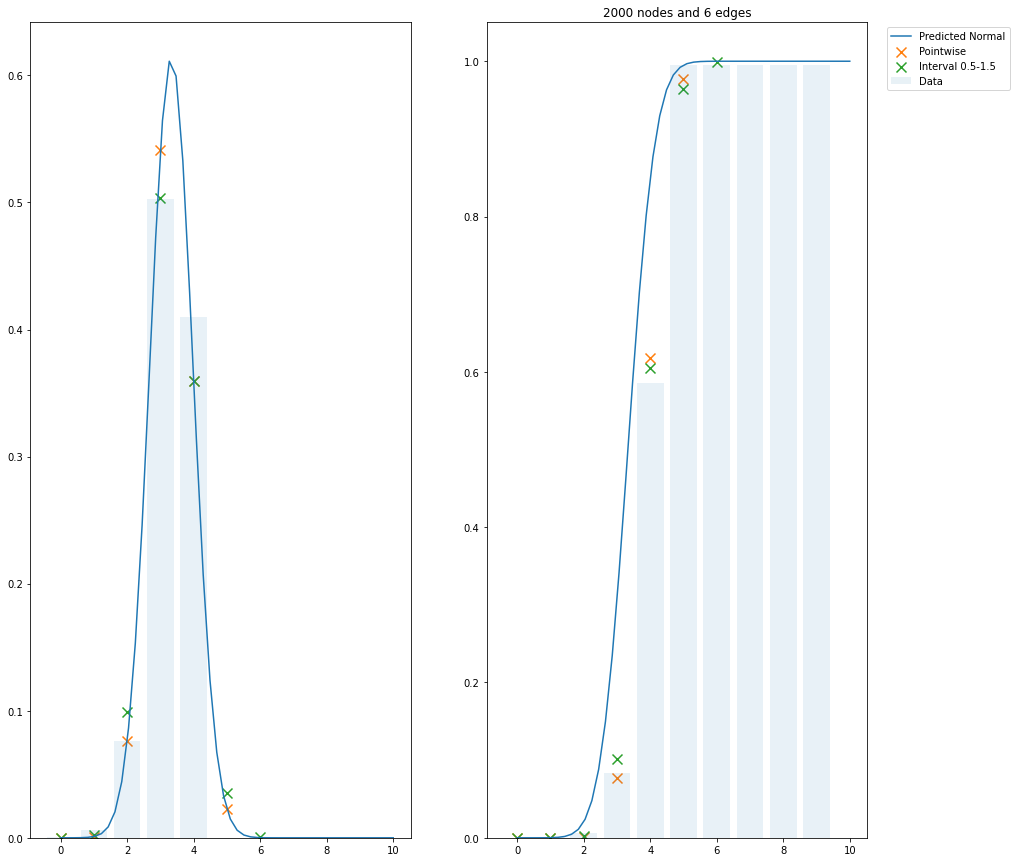

In [26]:
mu, si = prediction(nodes, edges)
discretization(testcase["freq"], mu, si, nodes, edges)

## Determining Forwarding Probabilities

From the given results we can now compute forwarding probabilities for our algorithm.
For this we have to first compute $\mathfrak{f}'$ and the $p_t$ based on $\mathfrak{f}'.$

In [27]:
pts,fo,fp = determine_pt(1345,6)

$ f'_4(3) = f_4(i) + max(\left( \sum_{j=4 }^4f_4(j)-f'_4(j)\right),\left(f'_5(4) + \sum_{j=4 }^3 (f'_5(j) - f'_4(j)) - f_4(3)\right)) = 0.8241517226242013 + max(0.0,-0.5635327167953008) = = 0.824 $

$ f'_3(2) = f_3(i) + max(\left( \sum_{j=3 }^3f_3(j)-f'_3(j)\right),\left(f'_4(3) + \sum_{j=3 }^2 (f'_4(j) - f'_3(j)) - f_3(2)\right)) = 0.9257344069661781 + max(0.0,-0.10158268434197681) = = 0.926 $

$ f'_2(1) = f_2(i) + max(\left( \sum_{j=2 }^2f_2(j)-f'_2(j)\right),\left(f'_3(2) + \sum_{j=2 }^1 (f'_3(j) - f'_2(j)) - f_2(1)\right)) = 0.9228917044086453 + max(0.0,0.002842702557532828) = = 0.926 $

$ f'_1(0) = f_1(i) + max(\left( \sum_{j=1 }^1f_1(j)-f'_1(j)\right),\left(f'_2(1) + \sum_{j=1 }^0 (f'_2(j) - f'_1(j)) - f_1(0)\right)) = 1.0 + max(0.0,-0.07426559303382185) = = 1.000 $

$ f'_4(2) = f_4(i) + max(\left( \sum_{j=3 }^4f_4(j)-f'_4(j)\right),\left(f'_5(4) + \sum_{j=3 }^3 (f'_5(j) - f'_4(j)) - f_4(2)\right)) = 0.16278880077250896 + max(0.0,-0.11695939754610357) = = 0.163 $

$ f'_3(1) = f_3(i) + max(\left( \sum_{j=2 }^3f_3(j)-f'_3(j)\right),\left(f'_4(3) + \sum_{j=2 }^2 (f'_4(j) - f'_3(j)) - f_3(1)\right)) = 0.06853909973390274 + max(0.0,-0.0073329833033706215) = = 0.069 $

$ f'_2(0) = f_2(i) + max(\left( \sum_{j=1 }^2f_2(j)-f'_2(j)\right),\left(f'_3(2) + \sum_{j=1 }^1 (f'_3(j) - f'_2(j)) - f_2(0)\right)) = 0.0771082955913547 + max(-0.002842702557532828,-0.008569195857451972) = = 0.074 $

$ f'_4(1) = f_4(i) + max(\left( \sum_{j=2 }^4f_4(j)-f'_4(j)\right),\left(f'_5(4) + \sum_{j=2 }^3 (f'_5(j) - f'_4(j)) - f_4(1)\right)) = 0.012052482621094854 + max(0.0,-0.00864893481209969) = = 0.012 $

$ f'_3(0) = f_3(i) + max(\left( \sum_{j=1 }^3f_3(j)-f'_3(j)\right),\left(f'_4(3) + \sum_{j=1 }^2 (f'_4(j) - f'_3(j)) - f_3(0)\right)) = 0.005726493299919194 + max(0.0,-0.001006993982194948) = = 0.006 $

$ f'_4(0) = f_4(i) + max(\left( \sum_{j=1 }^4f_4(j)-f'_4(j)\right),\left(f'_5(4) + \sum_{j=1 }^3 (f'_5(j) - f'_4(j)) - f_4(0)\right)) = 0.0010069939821948427 + max(0.0,-0.0007445522116795167) = = 0.001 $

$p_1(0) = 1-f_2(0) = 0.9257344069661781$

$p_2(0) = 1-\frac{f_3(0)}{f_2(0)} = 1-\frac{0.005726493299919194 }{ 0.07426559303382187} = 0.9228917044086452$


$p_2(1) = 1- \frac{f_3(1) - p_2(0) * f_2(0) } { f_2(1) } = 1-\frac{ (0.06853909973390274 - 0.9228917044086452 * 0.07426559303382187) }{ 0.9257344069661781 } = 0.9999999999999999$


$p_3(0) = 1-\frac{f_4(0)}{f_3(0)} = 1-\frac{0.0010069939821948427 }{ 0.005726493299919194} = 0.8241517226242014$


$p_3(1) = 1- \frac{f_4(1) - p_3(0) * f_3(0) } { f_3(1) } = 1-\frac{ (0.012052482621094854 - 0.8241517226242014 * 0.005726493299919194) }{ 0.06853909973390274 } = 0.8930102185199369$


$p_3(2) = 1- \frac{f_4(2) - p_3(1) * f_3(1) } { f_3(2) } = 1-\frac{ (0.16278880077250896 - 0.8930102185199369 * 0.06853909973390274) }{ 0.9257344069661781 } = 0.8902680038922999$


$p_4(0) = 1-\frac{f_5(0)}{f_4(0)} = 1-\frac{0.0007445522116795373 }{ 0.0010069939821948427} = 0.2606190058289005$


$p_4(1) = 1- \frac{f_5(1) - p_4(0) * f_4(0) } { f_4(1) } = 1-\frac{ (0.008911376582615012 - 0.2606190058289005 * 0.0010069939821948427) }{ 0.012052482621094854 } = 0.2823939196591819$


$p_4(2) = 1- \frac{f_5(2) - p_4(1) * f_4(1) } { f_4(2) } = 1-\frac{ (0.12036294535509871 - 0.2823939196591819 * 0.012052482621094854) }{ 0.16278880077250896 } = 0.28152675742387345$


$p_4(3) = 1- \frac{f_5(3) - p_4(2) * f_4(2) } { f_4(3) } = 1-\frac{ (0.6093621200217062 - 0.28152675742387345 * 0.16278880077250896) }{ 0.8241517226242013 } = 0.3162269745661118$


## Result Validation

First we check the changes in our target distribution $\mathfrak{f}$ to $\mathfrak{f}'$.
We will list both distributions, their difference as well as the computed forwarding probabilities.

In [28]:
print("f\tf'\tf-f'\tpt")
for i in range(1,len(fo)):
    print(f"{i}:")
    for j in range(len(fo[i])):
        print(f"{fo[i][j]:.3f}\t{fp[i][j]:.3f}\t{fp[i][j]-fo[i][j]:.3f}\t{pts[i-1][j] if i-1 < len(pts) else 'x'}")

f	f'	f-f'	pt
1:
1.000	1.000	0.000	0.9257344069661781
2:
0.077	0.074	-0.003	0.9228917044086452
0.923	0.926	0.003	0.9999999999999999
3:
0.006	0.006	0.000	0.8241517226242014
0.069	0.069	0.000	0.8930102185199369
0.926	0.926	0.000	0.8902680038922999
4:
0.001	0.001	0.000	0.2606190058289005
0.012	0.012	0.000	0.2823939196591819
0.163	0.163	0.000	0.28152675742387345
0.824	0.824	0.000	0.3162269745661118
5:
0.001	0.001	0.000	x
0.009	0.009	0.000	x
0.120	0.120	0.000	x
0.609	0.609	0.000	x
0.261	0.261	0.000	x


### Validating via the Transition Matrix

We generate the explicit transition matrices $M_t$ and the desired goal states $P_t$ from the previously obtained results.

In [29]:
def gen_Mt(pt):
    mat = np.zeros((len(pt)+1,len(pt)))
    np.fill_diagonal(mat[1:], pt)
    np.fill_diagonal(mat, [1-_ for _ in pt])    
    return mat

Pt = [np.array(_) for _ in fp]
Mt = [gen_Mt(pt) for pt in pts]

We check if the operation using the matrix yields the desired output.
To prevent issues with precision we apply numpys isclose method, which will result in a true value when two arrays are identical below a certain threshold, i.e., $m_{i,j}-n_{i,j} < \epsilon.$

In [30]:
from IPython.display import display, Markdown
for i,(M,P,Tar) in enumerate(zip(Mt,Pt[1:],Pt[2:])):
    display(Markdown(f"$M_{i+1}\\times P_{i+1} \\stackrel{{?}}{{=}} P_{i+2}$ {all(np.isclose(M.dot(P),Tar))}"))

$M_1\times P_1 \stackrel{?}{=} P_2$ True

$M_2\times P_2 \stackrel{?}{=} P_3$ True

$M_3\times P_3 \stackrel{?}{=} P_4$ True

$M_4\times P_4 \stackrel{?}{=} P_5$ True

## Privacy Evaluation Results

We calculate the expected tree depth for some parameters.

In [37]:
ATTACKER_FRACTION = 0.05
display(Markdown(f"$\beta={ATTACKER_FRACTION}$ nodes in the network are attackers."))
for ETA_WIDTH in [3, 5, 10]:
    display(Markdown(f"### $\eta={ETA_WIDTH}$"))
    for NETWORK_SIZE in [100,1000,10000]:
        display(Markdown(f"$N={NETWORK_SIZE}$ expected tree depth at attack: ${tree_depth_bound(NETWORK_SIZE, ETA_WIDTH, ATTACKER_FRACTION):.1f}$"))

$eta=0.05$ nodes in the network are attackers.

### $\eta=3$

$N=100$ expected tree depth at attack: $4.3$

$N=1000$ expected tree depth at attack: $3.9$

$N=10000$ expected tree depth at attack: $7.8$

### $\eta=5$

$N=100$ expected tree depth at attack: $2.5$

$N=1000$ expected tree depth at attack: $2.7$

$N=10000$ expected tree depth at attack: $2.7$

### $\eta=10$

$N=100$ expected tree depth at attack: $1.6$

$N=1000$ expected tree depth at attack: $1.7$

$N=10000$ expected tree depth at attack: $1.9$